# Neural Relational Inference for Interacting Systems
Notebook Author: Jin Yeom (jinyeom@utexas.edu)  
Original Authors: Thomas Kipf, Ethan Fetaya, Kuan-Chieh Wang, Max Welling, Richard Zemal

This notebook attempts to understand [this paper](https://arxiv.org/abs/1802.04687) (Kipf et al., 2018) by implementing the Neural Relational Inference (NRI) algorithm with PyTorch. Note that code for generating data is imported from the paper's [original implementation](https://github.com/hudl/relational-inference).

In [1]:
import time
from typing import Tuple, Sequence

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

## Data Generation

Below are scripts for generating trajectory data from particle simulations. Both `SpringSim` and `ChargedParticleSim` are adopted from the original implementation, and are also cleaned up for readability.

In [2]:
# from https://github.com/hudl/relational-inference/blob/master/data/synthetic_sim.py

class SpringSim(object):
    def __init__(self, 
                 n_balls: int = 5, 
                 box_size: float = 5.0, 
                 loc_std: float = 0.5, 
                 vel_norm: float = 0.5,
                 interaction_strength: float = 0.1, 
                 noise_var: float = 0.0):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._spring_types = np.array([0.0, 0.5, 1.0])
        self._delta_t = 0.001
        self._max_f = 0.1 / self._delta_t

    def energy(self, 
               loc: np.ndarray, 
               vel: np.ndarray,
               edges: np.ndarray) -> float:
        with np.errstate(divide='ignore'):
            k = 0.5 * (vel ** 2).sum()
            u = 0.0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        u += 0.5 * self.interaction_strength * edges[i, j] * (dist ** 2) / 2
            return u + k

    def _clamp(self,
               loc: np.ndarray,
               vel: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        assert np.all(loc < self.box_size * 3)
        assert np.all(loc > -self.box_size * 3)

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert np.all(loc <= self.box_size)
        
        vel[over] = -np.abs(vel[over])
        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        assert np.all(loc >= -self.box_size)
        
        vel[under] = np.abs(vel[under])
        return loc, vel

    def _l2(self, 
            a: np.ndarray, 
            b: np.ndarray) -> float:
        a_norm = (a ** 2).sum(axis=1).reshape(a.shape[0], 1)
        b_norm = (b ** 2).sum(axis=1).reshape(1, b.shape[0])
        dist = a_norm + b_norm - 2 * a.dot(b.transpose())
        return dist

    def sample_trajectory(self,
                          t: int = 10000,
                          sample_freq: int = 10,
                          spring_prob: Tuple[float] = (0.5, 0.0, 0.5)) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        n = self.n_balls
        assert t % sample_freq == 0
        t_save = int(t / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        
        # Sample edges
        edges = np.random.choice(self._spring_types,
                                 size=(self.n_balls, self.n_balls),
                                 p=spring_prob)
        edges = np.tril(edges) + np.tril(edges, -1).T
        np.fill_diagonal(edges, 0.0)
        
        # Initialize location and velocity
        loc = np.zeros((t_save, 2, n))
        vel = np.zeros((t_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        with np.errstate(divide='ignore'):
            forces_size = -self.interaction_strength * edges
            np.fill_diagonal(forces_size, 0.0)
            f = (forces_size.reshape(1, n, n) *
                 np.concatenate((np.subtract.outer(loc_next[0, :],
                                 loc_next[0, :]).reshape(1, n, n),
                                 np.subtract.outer(loc_next[1, :],
                                 loc_next[1, :]).reshape(1, n, n)))).sum(axis=-1)
            f[f > self._max_f] = self._max_f
            f[f < -self._max_f] = -self._max_f

            vel_next += self._delta_t * f
            for i in range(1, t):
                loc_next += self._delta_t * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                forces_size = - self.interaction_strength * edges
                np.fill_diagonal(forces_size, 0)
                f = (forces_size.reshape(1, n, n) *
                     np.concatenate((np.subtract.outer(loc_next[0, :],
                                     loc_next[0, :]).reshape(1, n, n),
                                     np.subtract.outer(loc_next[1, :],
                                     loc_next[1, :]).reshape(1, n, n)))).sum(axis=-1)
                f[f > self._max_f] = self._max_f
                f[f < -self._max_f] = -self._max_f                
                vel_next += self._delta_t * f
                
            # Add noise to observations
            loc += np.random.randn(t_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(t_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

loc.shape = (49, 2, 5)
vel.shape = (49, 2, 5)
Simulation time: 0.23871445655822754


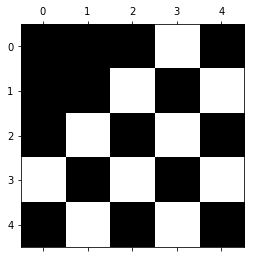

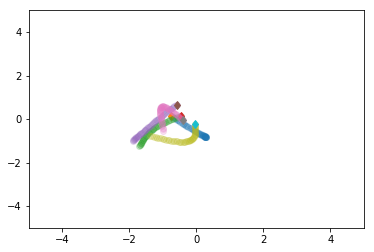

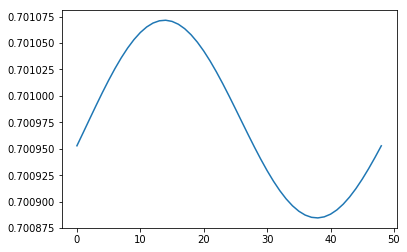

In [3]:
sim = SpringSim()

start_time = time.time()
loc, vel, edges = sim.sample_trajectory(t=5000, sample_freq=100)

print("loc.shape =", loc.shape)
print("vel.shape =", vel.shape)

duration = time.time() - start_time
print(f"Simulation time: {duration}")

plt.matshow(edges, cmap="gray")

plt.figure()
axes = plt.gca()
axes.set_xlim([-5.0, 5.0])
axes.set_ylim([-5.0, 5.0])
for i in range(loc.shape[-1]):
    plt.plot(loc[:, 0, i], loc[:, 1, i], 'o', alpha=0.2)
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'd')
    
plt.figure()
energies = [sim.energy(loc[i, :, :], vel[i, :, :], edges) for i in range(loc.shape[0])]
plt.plot(energies)
plt.show()

In [4]:
# from https://github.com/hudl/relational-inference/blob/master/data/synthetic_sim.py

class ChargedParticlesSim(object):
    def __init__(self, 
            n_balls: int = 5, 
            box_size: float = 5.0, 
            loc_std: float = 1.0, 
            vel_norm: float = 0.5,
            interaction_strength: float = 1.0, 
            noise_var: float = 0.0):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._charge_types = np.array([-1.0, 0.0, 1.0])
        self._delta_t = 0.001
        self._max_f = 0.1 / self._delta_t

    def _l2(self, 
            a: np.ndarray, 
            b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        a_norm = (a ** 2).sum(axis=1).reshape(a.shape[0], 1)
        b_norm = (b ** 2).sum(axis=1).reshape(1, b.shape[0])
        dist = a_norm + b_norm - 2 * a.dot(b.transpose())
        return dist

    def energy(self, 
               loc: np.ndarray, 
               vel: np.ndarray,
               edges: np.ndarray) -> float:
        with np.errstate(divide='ignore'):
            k = 0.5 * (vel ** 2).sum()
            u = 0.0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        u += 0.5 * self.interaction_strength * edges[i, j] / dist
            return u + k

    def _clamp(self, 
               loc: np.ndarray, 
               vel: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        assert np.all(loc < self.box_size * 3)
        assert np.all(loc > -self.box_size * 3)

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert np.all(loc <= self.box_size)

        vel[over] = -np.abs(vel[over])
        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        assert np.all(loc >= -self.box_size)
        
        vel[under] = np.abs(vel[under])
        return loc, vel

    def sample_trajectory(self, 
                          t: int = 10000, 
                          sample_freq: int = 10,
                          charge_prob: Tuple[float] = (0.5, 0.0, 0.5)) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        n = self.n_balls
        assert t % sample_freq == 0
        t_save = int(t / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        
        # Sample edges
        charges = np.random.choice(self._charge_types, 
                                   size=(self.n_balls, 1),
                                   p=charge_prob)
        edges = charges.dot(charges.transpose())
        
        # Initialize location and velocity
        loc = np.zeros((t_save, 2, n))
        vel = np.zeros((t_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        with np.errstate(divide='ignore'):
            l2 = self._l2(loc_next.transpose(), loc_next.transpose())
            l2_dist_power3 = np.power(l2, 1.5)

            # size of forces up to a 1/|r| factor
            # since I later multiply by an unnormalized r vector
            forces_size = self.interaction_strength * edges / l2_dist_power3
            np.fill_diagonal(forces_size, 0.0)
            assert np.abs(forces_size[diag_mask]).min() > 1e-10
            f = (forces_size.reshape(1, n, n) *
                 np.concatenate((np.subtract.outer(loc_next[0, :], 
                                                   loc_next[0, :]).reshape(1, n, n),
                                 np.subtract.outer(loc_next[1, :], 
                                                   loc_next[1, :]).reshape(1, n, n))))
            f = f.sum(axis=-1)
            f[f > self._max_f] = self._max_f
            f[f < -self._max_f] = -self._max_f

            vel_next += self._delta_t * f
            for i in range(1, t):
                loc_next += self._delta_t * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                l2 = self._l2(loc_next.transpose(), loc_next.transpose())
                l2_dist_power3 = np.power(l2, 1.5)
                forces_size = self.interaction_strength * edges / l2_dist_power3
                np.fill_diagonal(forces_size, 0)

                f = (forces_size.reshape(1, n, n) *
                     np.concatenate((np.subtract.outer(loc_next[0, :], 
                                                       loc_next[0, :]).reshape(1, n, n),
                                     np.subtract.outer(loc_next[1, :],
                                                       loc_next[1, :]).reshape(1, n, n))))
                f = f.sum(axis=-1)
                f[f > self._max_f] = self._max_f
                f[f < -self._max_f] = -self._max_f
                vel_next += self._delta_t * f
                
            # Add noise to observations
            loc += np.random.randn(t_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(t_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in power


loc.shape = (49, 2, 5)
vel.shape = (49, 2, 5)
Simulation time: 0.34509944915771484


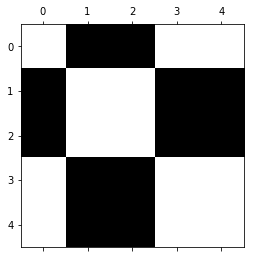

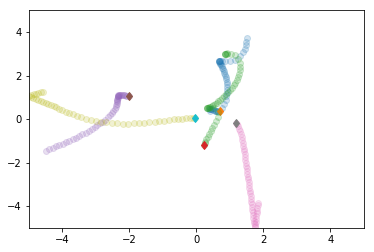

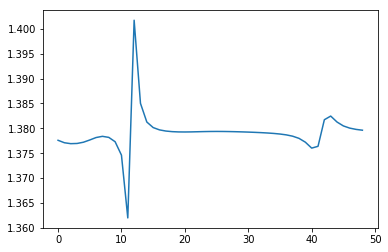

In [5]:
sim = ChargedParticlesSim()

start_time = time.time()
loc, vel, edges = sim.sample_trajectory(t=5000, sample_freq=100)

print("loc.shape =", loc.shape)
print("vel.shape =", vel.shape)

duration = time.time() - start_time
print(f"Simulation time: {duration}")

plt.matshow(edges, cmap="gray")

plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
for i in range(loc.shape[-1]):
    plt.plot(loc[:, 0, i], loc[:, 1, i], 'o', alpha=0.2)
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'd')
    
plt.figure()
energies = [sim.energy(loc[i, :, :], vel[i, :, :], edges) for i in range(loc.shape[0])]
plt.plot(energies)
plt.show()

## Graph Neural Network

$$
\begin{align*}
v \rightarrow e &: h^l_{(i, j)} = f^l_{e}([h^l_i, h^l_j]) \\
e \rightarrow v &: h^{l + 1}_j = f^l_{v}([\sum_{i \in N_j}h^l_{(i, j)}])
\end{align*}
$$

In [6]:
def node2edge(h: torch.Tensor, 
              m_in: torch.Tensor, 
              m_out: torch.Tensor) -> torch.Tensor:
    # assuming that the shape of x is (t, f, n),
    h_in = torch.matmul(m_in, h)
    h_out = torch.matmul(m_out, h)
    return torch.cat([h_in, h_out], dim=2)

def edge2node(h: torch.Tensor, m_in: torch.Tensor) -> torch.Tensor:
    # since M_in for edges is the transpose of M_in for nodes,
    return torch.matmul(m_in.t(), h)

In [7]:
class TwoLayerFcNet(nn.Module):
    r"""
    Two-layered fully connected neural network with dropout and 
    batch normalization, as described in the NRI paper (Kipf, et al.).
    """
    def __init__(self, 
                 in_dim: int, 
                 hid_dim: int, 
                 out_dim: int, 
                 dropout_rate: float = 0.5):
        super(TwoLayeredFullyConnectedNet, self).__init__()
        self.fc0 = nn.Linear(in_dim, hid_dim, bias=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hid_dim, out_dim, bias=True)
        self.bn = nn.BatchNorm1d(out_dim)
    
    def forward(self, x):
        x = F.elu(self.fc0(x))
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        return self.bn(x)

## Extending with VQ-VAE

As the NRI model attempts to learn discrete representations of graphs, one can imagine a direct extension of the NRI algorithm with [VQ-VAE](https://arxiv.org/abs/1711.00937v2) (Oord, et al.), a simple generative model that learns discrete representations.

## References
- Neural Relational Inference for Interacting Systems, [arXiv:1802.04687v2 \[stat.ML\]](https://arxiv.org/abs/1802.04687)
- Neural Discrete Representation Learning, [arXiv:1711.00937v2 \[cs.LG\]](https://arxiv.org/abs/1711.00937v2)